# Clustering Stocks with a Self-Organizing Map (SOM)

In this project, we aim to cluster stocks based on their daily price variation using a Self-Organizing Map (SOM) algorithm. The SOM is a type of artificial neural network that can learn the underlying structure of high-dimensional data and group similar data points together.

To begin, we'll retrieve the list of tickers for the S&P600 companies from Wikipedia using web scraping techniques with Python libraries such as BeautifulSoup and requests. The S&P600 is an index of small-cap stocks in the United States, making it a relevant choice for this project.

Next, we'll use the yfinance API to collect historical stock prices for each company in the S&P600 over the past five years. We'll then preprocess and clean the data to ensure that each stock has equal weight in the clustering analysis.

After the data has been cleaned, we'll compute the daily returns for each stock by calculating the percentage change in price from one day to the next. This allows us to capture the relative price variation over time, which is an important factor in clustering stocks.

Finally, we'll use the SOM algorithm to cluster the stocks into groups with similar daily price variation. This will enable us to identify patterns and similarities between the stocks that may not be immediately apparent from raw price data.

Overall, this project will provide a step-by-step guide to clustering stocks with a SOM algorithm, from retrieving the data to interpreting the clustering results.


#### Scrap Wikipedia's page

This code scrapps the wikipedia S&P600's page, to retrieve the list of tickers.

In [5]:
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup
import math
from minisom import MiniSom
import numpy as np
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

df = pd.DataFrame()
# request this url https://en.wikipedia.org/wiki/List_of_S%26P_600_companies
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_600_companies'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
# get the table by the id constituents
table = soup.find('table', {'id': 'constituents'})
ticker_list = []
# iterate over the tr balise in the table
for tr in table.find_all('tr'):
    # get the first td balise in the tr balise
    td = tr.findAll('td')
    # if the td balise is not empty
    if td is not None and len(td) > 1:
        # get the first a balise in the td balise
        a = td[1].find('a')
        # if the a balise is not empty
        if a is not None:
            # get the text of the a balise
            ticker = a.text
            # add the ticker to the list
            ticker_list.append(ticker)


#### Retrieving Historical Stock Prices

Next, we'll use the yfinance API to retrieve historical stock prices for each company in the S&P600. Specifically, we'll be collecting the stock prices for the past five years.

To ensure that we have enough data to accurately cluster the stocks, we'll only save the stock prices if there are at least number_of_days / 2 data points available. For example, if number_of_days is set to 252 (the number of trading days in a year), we'll only save the stock prices if there are at least 126 data points available.

This ensures that we have enough data to accurately capture the stock price variation over time. If there are not enough data points available, the stock prices will not be saved and will not be included in the clustering analysis.

Once we've retrieved and saved the historical stock prices, we'll preprocess and clean the data to prepare it for clustering with the SOM algorithm.





In [ ]:
index = 0
df_list = []
period = '5y'
number_of_days = 5*365
ticker_downloaded = []
for ticker in ticker_list:
    print(index, '/', len(ticker_list))
    df_temp = yf.Ticker(ticker).history(period=period)
    if len(df_temp) < number_of_days//2:
        continue
    else:
        df_temp['Daily Return'] = df_temp['Close'].pct_change()
        ticker_downloaded.append(ticker)
        df_list.append(df_temp)
    index += 1
len(df_list)


In [ ]:
df_list_daily_return = []
for df in df_list:
    df_list_daily_return.append(df['Daily Return'])

[df.dropna(inplace=True) for df in df_list_daily_return]

#### Plot the first 100 series

In [ ]:
# plot the first 100 series
import matplotlib.pyplot as plt
data_to_plot = df_list_daily_return[:50]
fig, axs = plt.subplots(10,5,figsize=(25,25))
fig.suptitle('Series')
for i in range(10):
    for j in range(5):
        if i*4+j+1>len(data_to_plot):
            continue
        axs[i, j].plot(data_to_plot[i*4+j].values)
        axs[i, j].set_title(ticker_downloaded[i*4+j])
plt.show()

In [ ]:
series_lengths = {len(series) for series in df_list_daily_return}
print(series_lengths)

#### Find the longest series

In [ ]:
max_len = max(series_lengths)
longest_series = None
for series in df_list_daily_return:
    if len(series) == max_len:
        longest_series = series
print(len(longest_series))

#### Reindex all series based on the longest one, and fill them with NaNs

In [11]:
problems_index = []

for i in range(len(df_list_daily_return)):
    if len(df_list_daily_return[i])!= max_len:
        problems_index.append(i)
        df_list_daily_return[i] = df_list_daily_return[i].reindex(longest_series.index)

In [12]:
def nan_counter(list_of_series):
    nan_polluted_series_counter = 0
    for series in list_of_series:
        if series.isnull().sum().sum() > 0:
            nan_polluted_series_counter+=1
    print(nan_polluted_series_counter)

In [ ]:
nan_counter(df_list_daily_return)

#### Interpolate the NaNs

In [14]:
for i in problems_index:
    df_list_daily_return[i].interpolate(limit_direction="both",inplace=True, method='linear')

In [ ]:
nan_counter(df_list_daily_return)

In [ ]:
df_list_daily_return

#### Normalize the data between 0 and 1

In [16]:
from sklearn.preprocessing import MinMaxScaler

for i in range(len(df_list_daily_return)):
    scaler = MinMaxScaler()
    df_list_daily_return[i] = MinMaxScaler().fit_transform(df_list_daily_return[i].values.reshape(-1,1))
    df_list_daily_return[i]= df_list_daily_return[i].reshape(len(df_list_daily_return[i]))

In [17]:
print("max: "+str(max(df_list_daily_return[0]))+"\tmin: "+str(min(df_list_daily_return[0])))
print(df_list_daily_return[0][:5])

max: 1.0	min: 0.0
[0.2467919  0.30975377 0.32866441 0.32819781 0.28989801]


#### Train the SOM

In [ ]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(df_list_daily_return))))

som = MiniSom(som_x, som_y,len(df_list_daily_return[0]), sigma=2, learning_rate = 0.0001)

som.random_weights_init(df_list_daily_return)
som.train(df_list_daily_return, 50000)

In [ ]:
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5)
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

#### Plot the clusters


In [ ]:
win_map = som.win_map(df_list_daily_return)
# Returns the mapping of the winner nodes and inputs
# plot clusters as point in a 2D map


plot_som_series_averaged_center(som_x, som_y, win_map)

#### Print the tickers of each cluster

In [ ]:
# Obtenir la carte des nœuds gagnants
win_map = som.win_map(df_list_daily_return)

# Initialiser une liste de labels pour chaque cluster
cluster_labels = [[] for i in range(som_x * som_y)]

# Parcourir la liste de données et extraire les labels correspondants à chaque cluster
for i, data in enumerate(df_list_daily_return):
    # Trouver le nœud gagnant correspondant à la série de données
    node = som.winner(data)
    # Ajouter le label correspondant à la série de données à la liste de labels du cluster correspondant
    cluster_labels[node[0] * som_y + node[1]].append(ticker_downloaded[i])

# Afficher les labels pour chaque cluster
for i in range(som_x * som_y):
    print("Cluster ", i+1, " : ", cluster_labels[i])

#### Plot all close values of a cluster

In [ ]:
cluster_number = 22

fig, axs = plt.subplots(1,1,figsize=(25,25))
fig.suptitle('Clusters')
for ticker in cluster_labels[cluster_number]:
    axs.plot(df_list[ticker_downloaded.index(ticker)]['Close'].values)
    axs.set_title(f"Cluster {cluster_number}")
axs.legend(cluster_labels[cluster_number])

In [ ]:
def plot_som_series_dba_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5)
                axs[cluster].plot(dtw_barycenter_averaging(np.vstack(win_map[cluster])),c="red") # I changed this part
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

In [ ]:
cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")

plt.figure(figsize=(25,5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n,cluster_c)
plt.show()

## K-Means

In [ ]:
cluster_count = math.ceil(math.sqrt(len(df_list_daily_return)))
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

labels = km.fit_predict(df_list_daily_return)

In [ ]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(df_list_daily_return[i],c="gray",alpha=0.4)
                cluster.append(df_list_daily_return[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0

plt.show()

In [ ]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
plt.figure(figsize=(30,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [ ]:
# print each tickers of all the clusters

for i in range(cluster_count):
    print("Cluster ", i, " : ", [ticker_downloaded[j] for j in range(len(labels)) if labels[j] == i])

In [ ]:
# plot each close value of a cluster
cluster_number = 18

fig, axs = plt.subplots(1,1,figsize=(25,25))
fig.suptitle('Clusters')
for i in range(len(labels)):
    if labels[i] == cluster_number:
        axs.plot(df_list[i]['Close'].values)
        # set legend to ticker
        axs.legend([ticker_downloaded[i]])
        axs.set_title(f"Cluster {cluster_number}")

## PCA : Principal Component Analysis, a dimensionality reduction technique

In [ ]:
pca = PCA(n_components=2)

df_list_daily_return_transformed = pca.fit_transform(df_list_daily_return)

In [ ]:
plt.figure(figsize=(25,25))
plt.scatter(df_list_daily_return_transformed[:,0],df_list_daily_return_transformed[:,1], s=300)
plt.show()

## K-Means on PCA

In [ ]:
kmeans = KMeans(n_clusters=cluster_count,max_iter=5000)

labels = kmeans.fit_predict(df_list_daily_return_transformed)

In [ ]:
plt.figure(figsize=(25,25))
plt.scatter(df_list_daily_return_transformed[:, 0], df_list_daily_return_transformed[:, 1], c=labels, s=300)
plt.show()

In [ ]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["cluster_"+str(i) for i in range(cluster_count)]
plt.figure(figsize=(30,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [ ]:
# print each close value of a cluster
cluster_number = 2

fig, axs = plt.subplots(1,1,figsize=(25,25))
fig.suptitle('Clusters')
for i in range(len(labels)):
    if labels[i] == cluster_number:
        axs.plot(df_list[i]['Close'].values)
        # set legend to ticker
        axs.legend([ticker_downloaded[i]])
        axs.set_title(f"Cluster {cluster_number}")

## Autoencoder

In [19]:
# Create a encoder decoder model with Pytorch
import torch
import torch.nn as nn

class AutoEncodeurCust(nn.Module):
    def __init__(self,input_features, coded_features,hidden_size_1,hidden_size_2,hidden_size_3):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.encoder = nn.Sequential(
            nn.Linear(input_features, hidden_size_1),
            nn.Sigmoid(),
            nn.Linear(hidden_size_1, hidden_size_2),
            nn.Sigmoid(),
            nn.Linear(hidden_size_2, hidden_size_3),
            nn.Sigmoid(),
            nn.Linear(hidden_size_3, coded_features),
        )
        self.decoder = nn.Sequential(
            nn.Linear(coded_features, hidden_size_3),
            nn.Sigmoid(),
            nn.Linear(hidden_size_3, hidden_size_2),
            nn.Sigmoid(),
            nn.Linear(hidden_size_2, hidden_size_1),
            nn.Sigmoid(),
            nn.Linear(hidden_size_1, input_features),
        )

    def forward(self, features):
        encoded = self.encoder(features)
        decoded = self.decoder(encoded)
        return decoded


In [20]:
hidden_size_1 = len(df_list_daily_return[0])//2
hidden_size_2 = len(df_list_daily_return[0])//4
hidden_size_3 = len(df_list_daily_return[0])//8
model = AutoEncodeurCust(input_features=len(df_list_daily_return[0]), coded_features=2, hidden_size_1=hidden_size_1, hidden_size_2=hidden_size_2, hidden_size_3=hidden_size_3)


In [21]:
model

AutoEncodeurCust(
  (encoder): Sequential(
    (0): Linear(in_features=1258, out_features=629, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=629, out_features=314, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=314, out_features=157, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=157, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=157, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=157, out_features=314, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=314, out_features=629, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=629, out_features=1258, bias=True)
  )
)

In [31]:
# Create a loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)

In [23]:
# Create training dataset
X = torch.tensor(df_list_daily_return, dtype=torch.float32, device=model.device)
Y = torch.tensor(df_list_daily_return, dtype=torch.float32, device=model.device)

/var/folders/rf/fpw8fl0j2cdbf_hq8cp2hfz80000gn/T/ipykernel_7344/569242467.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  X = torch.tensor(df_list_daily_return, dtype=torch.float32, device=model.device)


In [24]:
X

tensor([[0.2468, 0.3098, 0.3287,  ..., 0.4037, 0.4189, 0.3515],
        [0.5885, 0.6068, 0.6014,  ..., 0.5982, 0.6091, 0.6298],
        [0.4696, 0.5801, 0.5346,  ..., 0.5251, 0.5183, 0.5098],
        ...,
        [0.3888, 0.5030, 0.5244,  ..., 0.5301, 0.4133, 0.4954],
        [0.4753, 0.4880, 0.5003,  ..., 0.3690, 0.4753, 0.5031],
        [0.3573, 0.5497, 0.7175,  ..., 0.5650, 0.5512, 0.4967]])

In [ ]:
# Train the model
epochs = 100000

for epoch in range(epochs):
    # shuffle X and Y, but keep the same order
    permutation = torch.randperm(X.size()[0])
    X = X[permutation]
    Y = Y[permutation]
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, X)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 200 == 0:
        print(f"epoch: {epoch+1}, loss = {loss.item():.9f}")

epoch: 200, loss = 0.002701595
epoch: 400, loss = 0.002747845
epoch: 600, loss = 0.002698854
epoch: 800, loss = 0.002696827
epoch: 1000, loss = 0.002703601
epoch: 1200, loss = 0.002693208
epoch: 1400, loss = 0.002694304
epoch: 1600, loss = 0.002688921
epoch: 1800, loss = 0.002695176
epoch: 2000, loss = 0.002698893
epoch: 2200, loss = 0.002687327
epoch: 2400, loss = 0.002676279
epoch: 2600, loss = 0.002675221
epoch: 2800, loss = 0.002682639
epoch: 3000, loss = 0.002668261
epoch: 3200, loss = 0.002664806
epoch: 3400, loss = 0.002662388
epoch: 3600, loss = 0.002673624
epoch: 3800, loss = 0.002657974
epoch: 4000, loss = 0.002651515
epoch: 4200, loss = 0.002765709
epoch: 4400, loss = 0.002814953
epoch: 4600, loss = 0.002690883
epoch: 4800, loss = 0.002650605
epoch: 5000, loss = 0.002662008
epoch: 5200, loss = 0.002680278
epoch: 5400, loss = 0.002648556
epoch: 5600, loss = 0.002761283
epoch: 5800, loss = 0.002739773
epoch: 6000, loss = 0.002724576
epoch: 6200, loss = 0.002714584
epoch: 6400,

In [154]:
del model

In [30]:
del optimizer

In [26]:
encoded = model.encoder(X)

In [27]:
encoded

tensor([[ 1.3065, -1.6900],
        [-2.3089, -4.0681],
        [-4.9012, -4.1361],
        ...,
        [-1.2001, -3.3744],
        [ 0.9089, -1.9648],
        [-0.7978, -3.1066]], grad_fn=<AddmmBackward0>)

In [28]:
decoded = model.decoder(encoded)

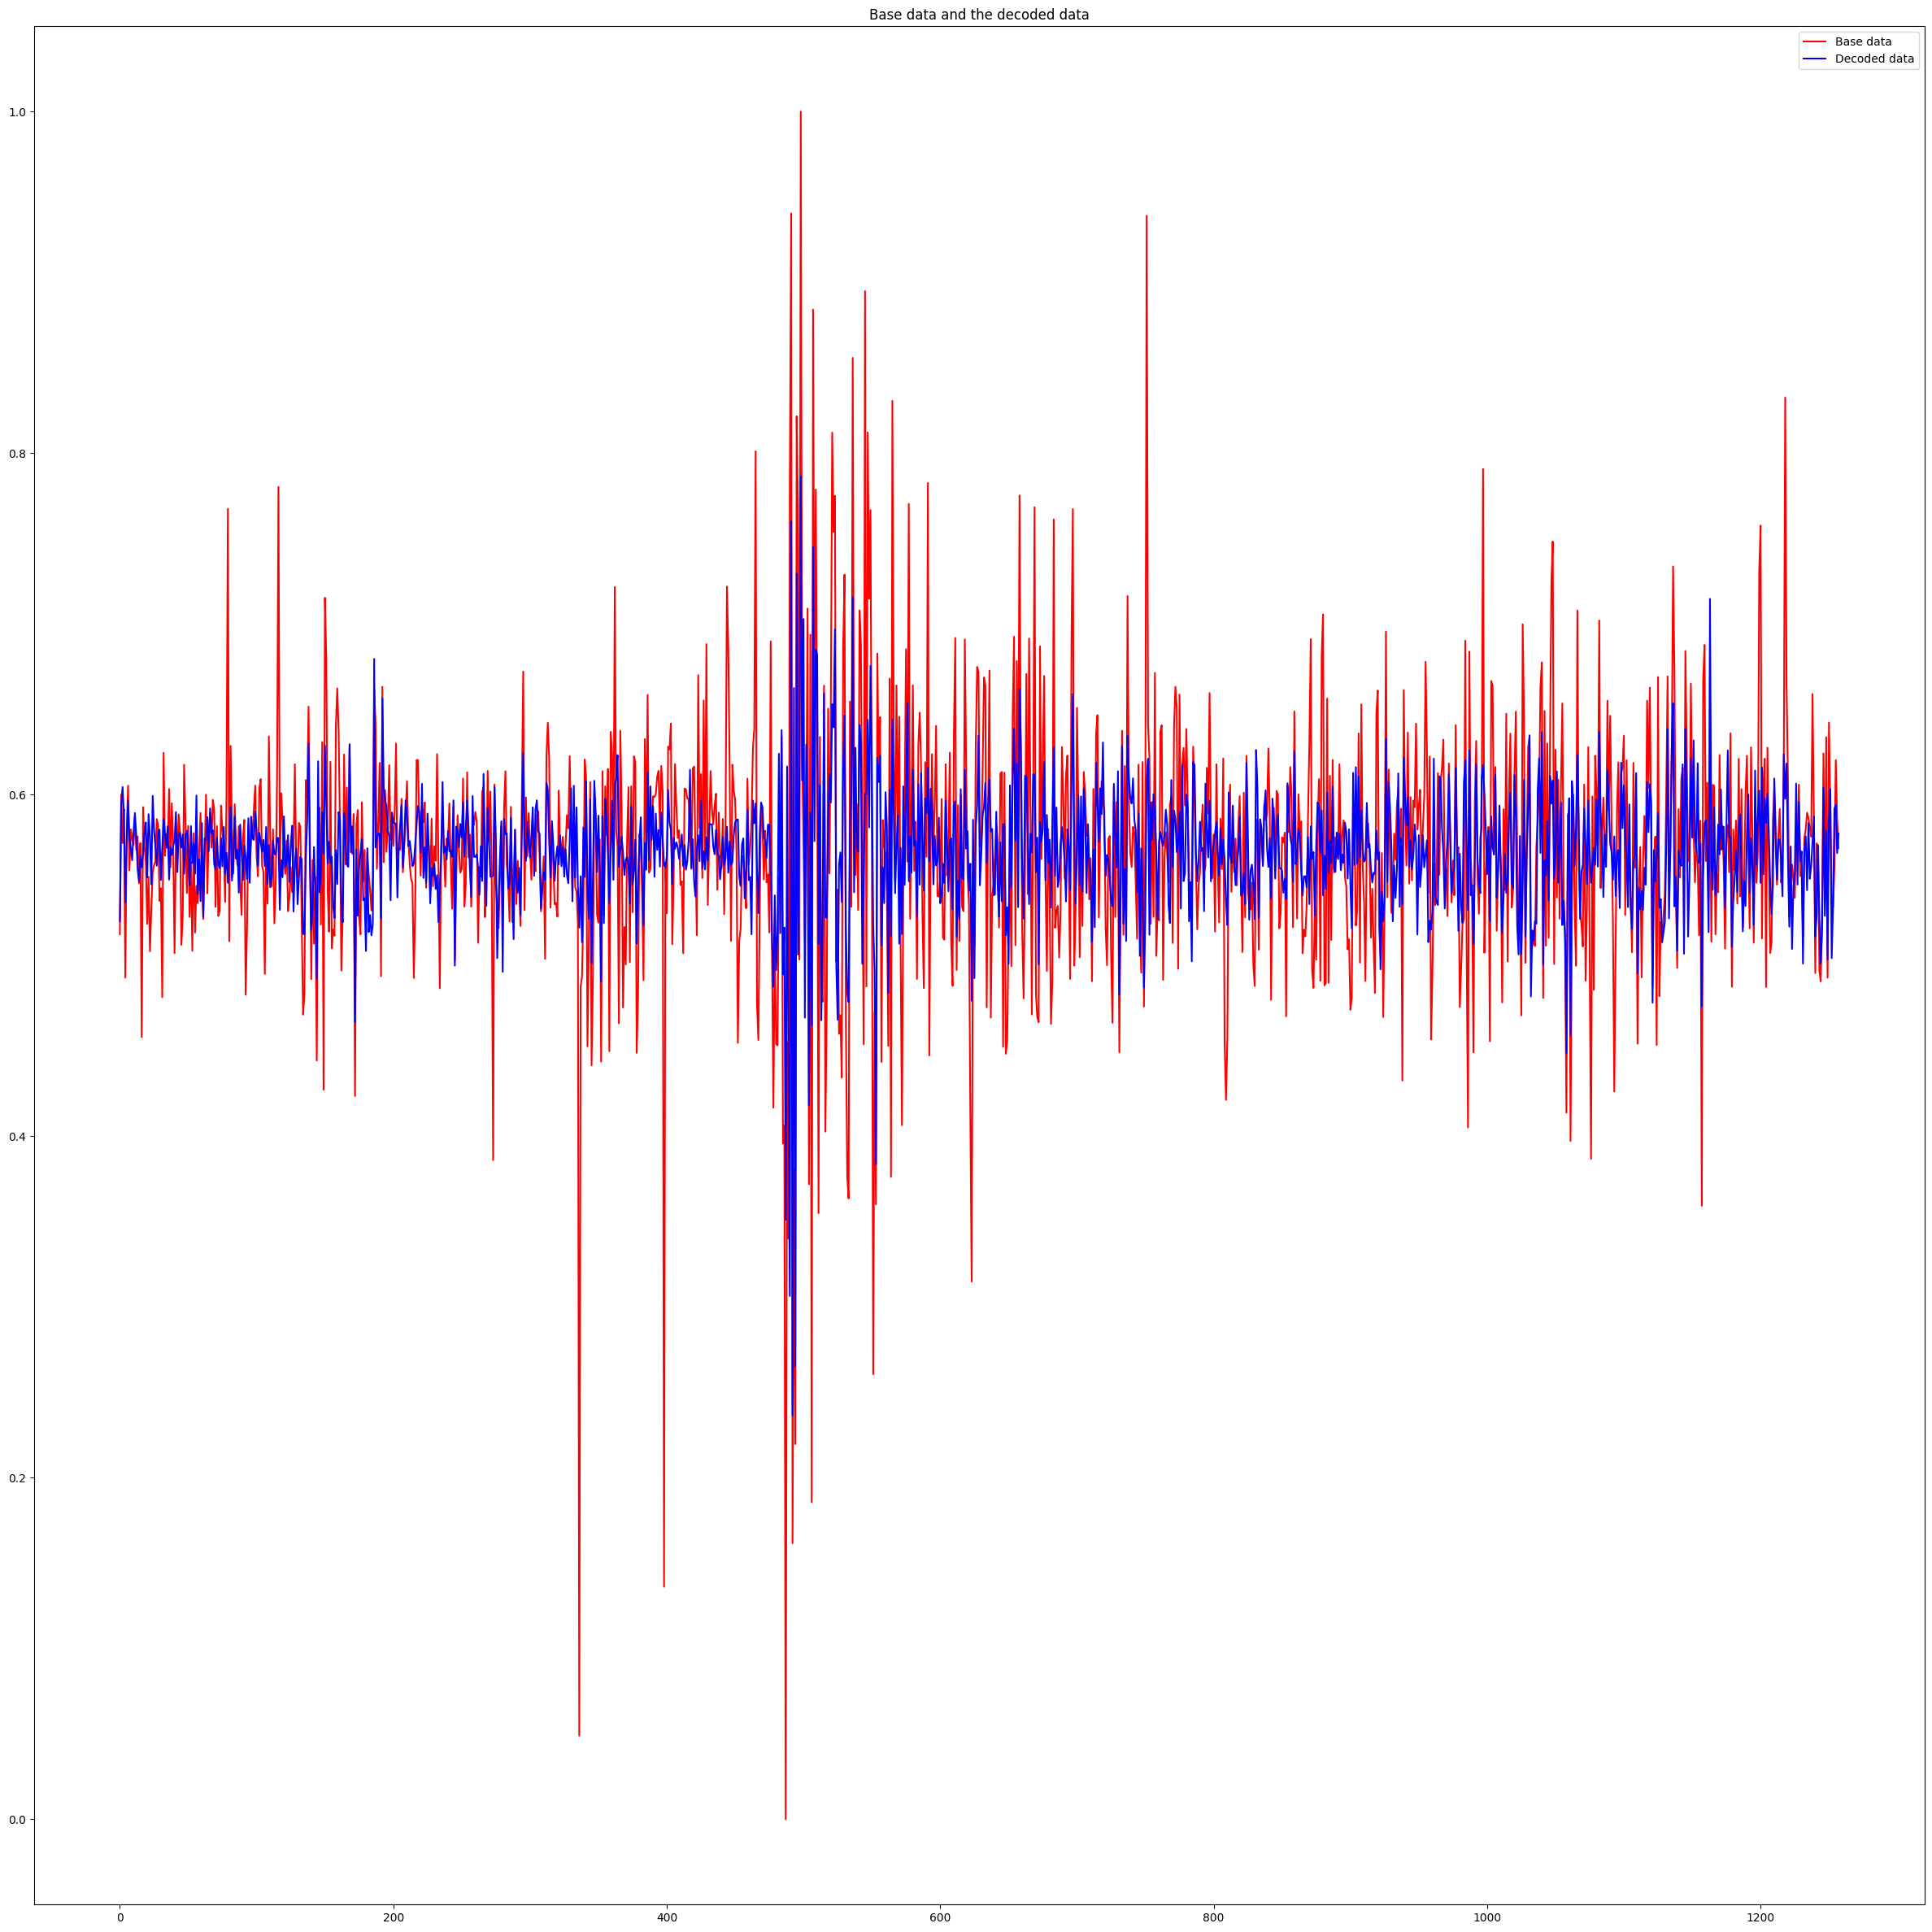

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 30))
plt.title("Base data and the decoded data")
plt.plot(X[0].detach().numpy(), c="red")
plt.plot(decoded[0].detach().numpy(), c="blue")
plt.legend(["Base data", "Decoded data"]) # ajouter les labels des deux courbes
plt.show()
